In [1]:
%reload_ext autoreload
%autoreload 2

In [34]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [7]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\layer_bias_replays.csv')
df.keys()

Index(['Unnamed: 0', 'start', 'stop', 'peaks', 'amplitude', 'duration',
       'frequency', 'detectorName', 'ripple_channel', 'event_spk_thres',
       'basepath', 'basename', 'animal', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle', 'traj_dist',
       'traj_speed', 'traj_step', 'replay_type', 'pop_partic', 'decoding_r2',
       'decoding_r2_pval', 'decoding_median_error', 'total_units', 'direction',
       'n_replays', 'sig_unit_bias', 'n_deep_obs', 'n_sup_obs', 'event_id',
       'balance', 'effective', 'equal', 'ins', 'isns', 'gmm_labels',
       'constant'],
      dtype='object')

In [233]:
basepath = "Z:\Data\HMC1\day9"
# st,cell_metrics = loading.load_spikes(basepath,putativeCellType="Pyr")
st,cell_metrics = loading.load_spikes(basepath)


In [226]:
replays_df = df[(df.basepath == basepath) & (df.score_pval_time_swap < 0.05)]

replays_epochs = nel.EpochArray([np.array([replays_df.start, replays_df.stop]).T])
replays_epochs.expand(0.05)

<EpochArray at 0x1a4a77a0910: 130 epochs> of length 24.8696 seconds

In [234]:
cell_metrics.brainRegion.value_counts()

PFC        186
MEC         82
CA1         80
Unknown     38
Name: brainRegion, dtype: int64

In [210]:
replays_df.keys()

Index(['Unnamed: 0', 'start', 'stop', 'peaks', 'amplitude', 'duration',
       'frequency', 'detectorName', 'ripple_channel', 'event_spk_thres',
       'basepath', 'basename', 'animal', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle', 'traj_dist',
       'traj_speed', 'traj_step', 'replay_type', 'pop_partic', 'decoding_r2',
       'decoding_r2_pval', 'decoding_median_error', 'total_units', 'direction',
       'n_replays', 'sig_unit_bias', 'n_deep_obs', 'n_sup_obs', 'event_id',
       'balance', 'effective', 'equal', 'ins', 'isns', 'gmm_labels',
       'constant'],
      dtype='object')

In [25]:
# st_ca1 = st.copy()
# st_ca1._data = st_ca1.data[cell_metrics.brainRegion.str.contains('CA1')]
# st_pfc = st.copy()
# st_pfc._data = st_pfc.data[cell_metrics.brainRegion.str.contains('PFC')]
# st_mec = st.copy()
# st_mec._data = st_mec.data[cell_metrics.brainRegion.str.contains('MEC')]

# st_ca1, st_pfc, st_mec

(<SpikeTrainArray at 0x1a442a17ac0: 80 units> at 20000 Hz,
 <SpikeTrainArray at 0x1a44103ef70: 186 units> at 20000 Hz,
 <SpikeTrainArray at 0x1a4429b0820: 82 units> at 20000 Hz)

In [235]:
n_spikes = []
for ep in replays_epochs:
    n_spikes.append(np.sum(st[:,pfc_idx][ep].n_events) / ep.length)

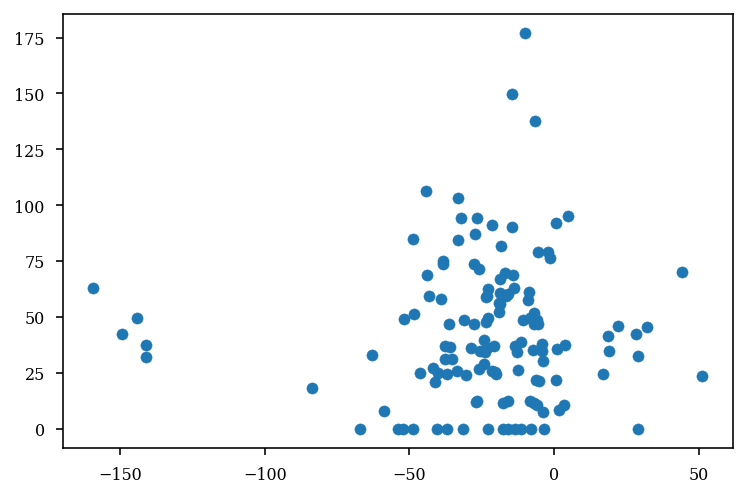

In [236]:
plt.scatter(replays_df.effective,n_spikes)

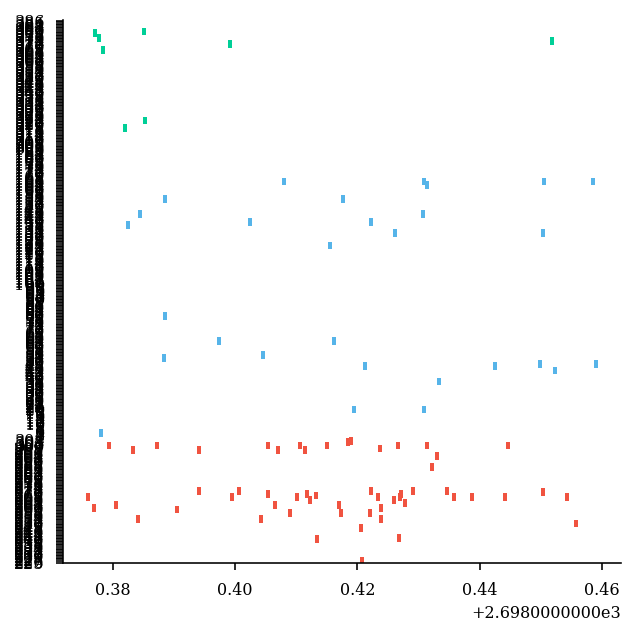

In [237]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))

ca1_idx = np.where(cell_metrics.brainRegion.str.contains('CA1'))[0]+1
pfc_idx = np.where(cell_metrics.brainRegion.str.contains('PFC'))[0]+1
mec_idx = np.where(cell_metrics.brainRegion.str.contains('MEC'))[0]+1

rip = 8
npl.rasterplot(st[:,ca1_idx][replays_epochs[rip]], lw=2,lh=5, ax=ax, color=npl.colors.sweet.red, vertstack=True)
npl.rasterplot(st[:,pfc_idx][replays_epochs[rip]], lw=2,lh=5, ax=ax, color=npl.colors.sweet.blue, vertstack=True)
npl.rasterplot(st[:,mec_idx][replays_epochs[rip]], lw=2,lh=5, ax=ax, color=npl.colors.sweet.green, vertstack=True)
sns.despine()



In [177]:
psth_z.shape[0]

101

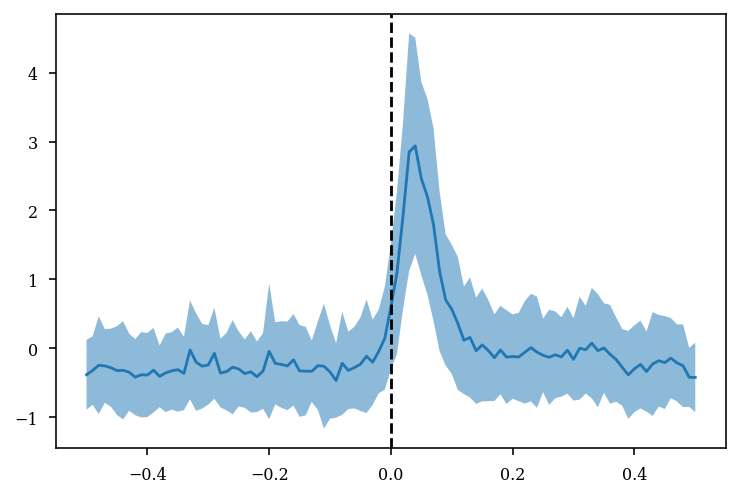

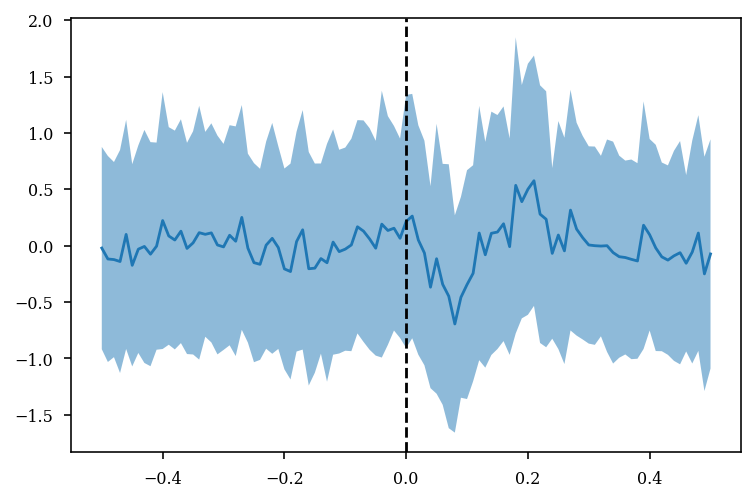

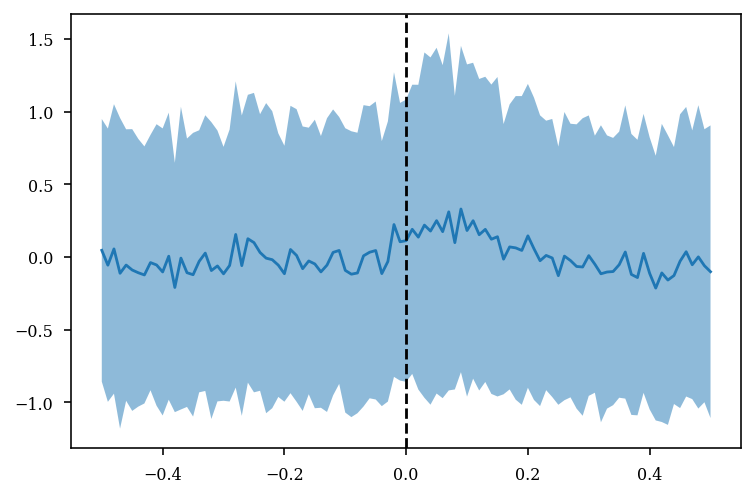

In [238]:
psth = functions.compute_psth(st[:,ca1_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100)
psth_z = stats.zscore(psth,axis=0)
plt.plot(np.mean(psth_z,axis=1))
plt.fill_between(psth.index, np.mean(psth_z,axis=1)-np.std(psth_z,axis=1), np.mean(psth_z,axis=1)+np.std(psth_z,axis=1), alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

psth = functions.compute_psth(st[:,mec_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100)
psth_z = stats.zscore(psth,axis=0)
plt.plot(np.mean(psth_z,axis=1))
plt.fill_between(psth.index, np.mean(psth_z,axis=1)-np.std(psth_z,axis=1), np.mean(psth_z,axis=1)+np.std(psth_z,axis=1), alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--')

plt.show()

psth = functions.compute_psth(st[:,pfc_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100)
psth_z = stats.zscore(psth,axis=0)
plt.plot(np.mean(psth_z,axis=1))
plt.fill_between(psth.index, np.mean(psth_z,axis=1)-np.std(psth_z,axis=1), np.mean(psth_z,axis=1)+np.std(psth_z,axis=1), alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--')


plt.show()

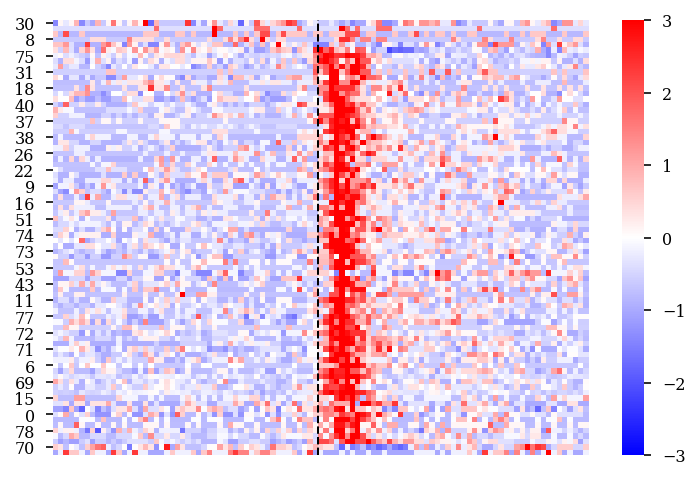

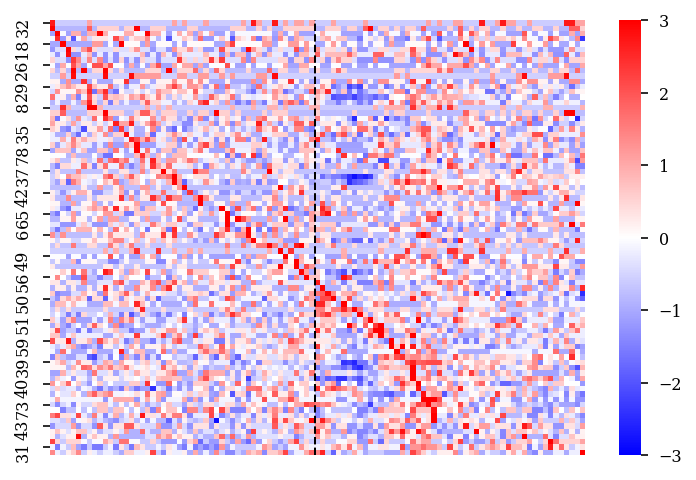

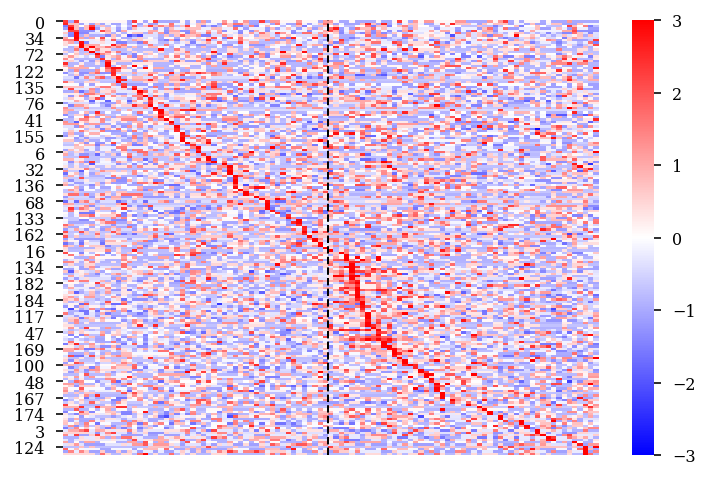

In [239]:
psth = functions.compute_psth(st[:,ca1_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100)
plt.figure()
ax = plt.gca()
sort_idx = np.argsort(np.argmax(psth.values,axis=0))
sns.heatmap(stats.zscore(psth,axis=0)[sort_idx].T,ax=ax,cmap="bwr",vmax=3,vmin=-3,xticklabels=False)
ax.axvline(50, color='k', lw=1, ls='--')

psth = functions.compute_psth(st[:,mec_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100)
plt.figure()
ax = plt.gca()
sort_idx = np.argsort(np.argmax(psth.values,axis=0))
sns.heatmap(stats.zscore(psth,axis=0)[sort_idx].T,ax=ax,cmap="bwr",vmax=3,vmin=-3,xticklabels=False)
ax.axvline(50, color='k', lw=1, ls='--')

psth = functions.compute_psth(st[:,pfc_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100)
plt.figure()
ax = plt.gca()
sort_idx = np.argsort(np.argmax(psth.values,axis=0))
sns.heatmap(stats.zscore(psth,axis=0)[sort_idx].T,ax=ax,cmap="bwr",vmax=3,vmin=-3,xticklabels=False)
ax.axvline(50, color='k', lw=1, ls='--')

In [155]:
bin_width=0.01
n_bins=100
times = np.linspace(-(n_bins*bin_width)/2,(n_bins*bin_width)/2,n_bins+1)
times
# np.where(times == 0)
# (times - times.min())[times == 0]

array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
        0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,
        0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,  0.2 ,  0.21,
        0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,  0.3 ,
        0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,  0.39,
        0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,  0.48,
        0.49,  0.5 ])

In [26]:
import neo
import numpy as np
import quantities as pq
from elephant.spike_train_generation import homogeneous_poisson_process
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import covariance

In [27]:
np.random.seed(1)
st1 = homogeneous_poisson_process(rate=10*pq.Hz, t_stop=10.0*pq.s)
st2 = homogeneous_poisson_process(rate=10*pq.Hz, t_stop=10.0*pq.s)
cov_matrix = covariance(BinnedSpikeTrain([st1, st2], bin_size=5*pq.ms))
cov_matrix

array([[ 0.05432316, -0.00152276],
       [-0.00152276,  0.04917234]])

In [31]:
st1.times

array([0.05396058, 0.18137311, 0.18138455, 0.21738582, 0.23325678,
       0.24294517, 0.26355663, 0.30595428, 0.35649954, 0.43389551,
       0.48822945, 0.60381742, 0.62668986, 0.83715959, 0.83993655,
       0.95094459, 1.00495369, 1.08675442, 1.10188171, 1.12395904,
       1.28527581, 1.63029853, 1.66790239, 1.78577274, 1.99483444,
       2.21984002, 2.22872798, 2.23271176, 2.25132429, 2.46181459,
       2.47216712, 2.52683099, 2.84357688, 2.91975488, 3.03748054,
       3.07538949, 3.19138538, 3.37133975, 3.37318551, 3.51187269,
       3.96160377, 4.09950214, 4.13241423, 4.28813642, 4.29903156,
       4.358433  , 4.59767906, 4.63243842, 4.66637461, 4.6803041 ,
       4.6822598 , 4.79583999, 4.81961853, 4.85048141, 4.9181248 ,
       4.92360871, 5.00896792, 5.02483567, 5.11382625, 5.23414301,
       5.24493878, 5.29839189, 5.41693976, 5.47041391, 5.47553834,
       5.55230309, 5.6613064 , 5.73364418, 6.02295228, 6.11127537,
       6.34499501, 6.35978409, 6.37478226, 6.53949172, 6.59018